# SVM Population decoding (Fig 7)
Population decoding of the object identity and modality condition based on support vector machine.

1) Modality-specific decoding (Fig 7A-C)
2) Modality-invariant decoding (Fig 7D-F)

In [12]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import random

from scipy import stats
import statsmodels.api as sm

import pingouin as pg

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date
import time

from joblib import Parallel, delayed

import h5py

In [13]:
# no top and right spines in all plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [14]:
# Make sure you change "mother_path" properly to run this code
mother_path = Path('C:/multimodal-object-recognition-PER/')

save_path = mother_path / 'result' / 'population decoding'
os.makedirs(save_path,exist_ok=True)

fig_path = mother_path / 'result' / 'figures'
os.makedirs(fig_path,exist_ok=True)

### Parameter setting

In [15]:
# colors for multimodal, vis-only, aud-only conditions
color = ['tab:purple','tab:blue','tab:red','tab:green']
color2 = ['cyan','magenta','gray']
linestyle = ['-',':']

today = str(date.today())

### Data preparation

In [16]:
cell_path = mother_path/'cell'    # individual cell data
cell_list = os.listdir(cell_path)

# load results from ANOVA
data_path = mother_path /'result'/'ANOVA'/'2023-07-10'
f = h5py.File(data_path/'2023-07-10_ANOVA_result.hdf5','r')

# load results from multiple linear regression
data2_path = mother_path /'result'/'multiple linear regression'/'2023-07-10'
f2 = h5py.File(data2_path/'2023-07-10_multiple_regression_result.hdf5','r')

In [17]:
def h5_to_df(f):
    keys = list(f.keys())
    attributes = {}
    
    for key in keys:
        attributes[key] = dict(f[key].attrs.items())
    
    df = pd.DataFrame.from_dict(attributes, orient='index')
    df.index.name = 'key'
    df = df.reset_index()
    
    return df

In [18]:
df = h5_to_df(f)
df = df[df['region']=='PER']
df.reset_index(inplace=True, drop=True)

for key in df['key']:
    if df.loc[df['key']==key, 'object cell'].item() == 0:
        df.loc[df['key']==key, 'category'] = 'none'
    else:
        if f2[key].attrs['response cell'] == 0:
            df.loc[df['key']==key, 'category'] = 'object'
        else:
            df.loc[df['key']==key, 'category'] = 'response'

In [19]:
# load multiple linear regression results and define cell categories (visual, auditory, crossmodal)
df2 = h5_to_df(f2)
df2 = df2[(df2['region']=='PER')&(df2['response cell']==0)]
df2.reset_index(inplace=True,drop=True)

for key in df2['key']:  
    
    if f[key].attrs['preferred object'] == 'Boy':
        df2.loc[df2['key']==key,'coef_pref_image'] = f2[f'{key}/basic/beta_coef'][0]
        df2.loc[df2['key']==key,'coef_pref_sound'] = f2[f'{key}/basic/beta_coef'][1]
        
        df2.loc[df2['key']==key,'coef_nonpref_image'] = f2[f'{key}/basic/beta_coef'][2]
        df2.loc[df2['key']==key,'coef_nonpref_sound'] = f2[f'{key}/basic/beta_coef'][3]

        beta_diff_shuffle = np.subtract(f2[f'{key}/basic_shuffle/beta_coef'][:,0],
                                        f2[f'{key}/basic_shuffle/beta_coef'][:,1])

    else:
        df2.loc[df2['key']==key,'coef_pref_image'] = f2[f'{key}/basic/beta_coef'][2]
        df2.loc[df2['key']==key,'coef_pref_sound'] = f2[f'{key}/basic/beta_coef'][3]
        
        df2.loc[df2['key']==key,'coef_nonpref_image'] = f2[f'{key}/basic/beta_coef'][0]
        df2.loc[df2['key']==key,'coef_nonpref_sound'] = f2[f'{key}/basic/beta_coef'][1]

        beta_diff_shuffle = np.subtract(f2[f'{key}/basic_shuffle/beta_coef'][:,2],
                                        f2[f'{key}/basic_shuffle/beta_coef'][:,3])


    beta_diff = df2.loc[df2['key']==key,'coef_pref_image']-df2.loc[df2['key']==key,'coef_pref_sound']
    beta_diff = beta_diff.item()
      
    visual_crit = np.percentile(beta_diff_shuffle,97.5)
    auditory_crit = np.percentile(beta_diff_shuffle,2.5)
    
    if beta_diff > visual_crit:
        df2.loc[df2['key']==key,'Category'] = 'visual'
    elif beta_diff < auditory_crit:
        df2.loc[df2['key']==key,'Category'] = 'auditory'
    else:
        df2.loc[df2['key']==key,'Category'] = 'crossmodal'

### Check the number of neurons available for population analysis

In [13]:
rat_list = np.sort(df['rat'].unique())
print(rat_list)

['600' '602' '640' '647' '654' '679' '699']


In [14]:
# none cell + object cell (response cell excluded)
cell_array = np.zeros((len(rat_list),int(df['session'].max())))
for i in range(len(df)):
    rat = df.loc[i, 'rat']
    rat_id = np.where(rat_list==rat)[0][0]
    ss = int(df.loc[i, 'session'])
    
    if df.loc[i,'category'] != 'response':
        cell_array[rat_id, ss-1] += 1

print('===== Object cells + None =====')        
print(cell_array)

===== Object cells + None =====
[[ 8. 11.  3. 11.  7.  0.  0.]
 [26. 19. 28. 16. 16.  0.  0.]
 [10. 13.  9.  4.  5.  0.  0.]
 [ 0.  0.  0. 15. 10.  8.  4.]
 [ 7.  4.  0.  0.  1.  0.  0.]
 [ 0.  2.  2.  3.  0.  1.  0.]
 [ 9.  9. 16. 15. 17.  7.  0.]]


In [15]:
# only object cell (response cell, none cell excluded)
cell_array = np.zeros((len(rat_list),int(df['session'].max())))
for i in range(len(df)):
    rat = df.loc[i, 'rat']
    rat_id = np.where(rat_list==rat)[0][0]
    ss = int(df.loc[i, 'session'])
    
    if df.loc[i,'category'] == 'object':
        cell_array[rat_id, ss-1] += 1

print('====== Only object cells ======')
print(cell_array)

====== Only object cells ======
[[ 5.  6.  2.  4.  5.  0.  0.]
 [15.  6. 10.  5.  8.  0.  0.]
 [ 7.  9.  4.  3.  3.  0.  0.]
 [ 0.  0.  0. 10.  4.  4.  4.]
 [ 3.  2.  0.  0.  1.  0.  0.]
 [ 0.  1.  0.  1.  0.  0.  0.]
 [ 4.  3.  6.  3.  8.  3.  0.]]


In [16]:
num_obj = np.sum(cell_array,axis=1)
print('# of object cells in each rat')
print('-----------------------------')
for i in range(len(rat_list)):
    print(f'LE{rat_list[i]}: {int(num_obj[i])}')

# of object cells in each rat
-----------------------------
LE600: 22
LE602: 44
LE640: 26
LE647: 22
LE654: 6
LE679: 2
LE699: 27


---

## Modality-specific decoding (Fig 7A-C)

Object and modality conditions (2 by 3) were classified using linear support vector machine (6-class classifier).

All object cells are used in this analysis.

In [20]:
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [18]:
def subsample(df, rat, num_trial, bin_size, time_bin, shuffle):
    scaler = StandardScaler()

    num_bin = int(90/bin_size)
    object_cell_list = df.loc[(df['rat']==rat)&(df['category']=='object'),'key'].to_numpy()

    # M by N array of subsampled firing rates
    # M = stimulus condition * number of subsampled trials
    # N = number of cells * number of time bins
    X = np.zeros((6*num_trial, len(object_cell_list)*time_bin))

    for i,cell_key in enumerate(object_cell_list):

        # load trial-by-trial firing rate data of a cell
        key = cell_key.zfill(4)
        cell_filename = list(cell_path.glob(f'{key}*.csv'))
        df_cell = pd.read_csv(cell_filename[0])
        df_cell.drop(df_cell[df_cell.Correctness==0].index,inplace=True)
        df_cell.reset_index(inplace=True,drop=True)

        # goal location (left or right) of each object condition
        boy_goal = df_cell.loc[df_cell['Visual']=='Boy','RWD_Loc'].values[0]
        egg_goal = df_cell.loc[df_cell['Visual']=='Egg','RWD_Loc'].values[0]

        # shuffling stimulus condition for permutation test
        if shuffle:
            cond_array = df_cell[['Type','RWD_Loc']].to_numpy()
            shuffled_cond_array = np.random.permutation(cond_array)
            df_cell[['Type','RWD_Loc']] = shuffled_cond_array

        # stimulus condition (identity x modality)
        cond = [(df_cell['Type']=='Multimodal')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Visual')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Auditory')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Multimodal')&(df_cell['RWD_Loc']==egg_goal),
                (df_cell['Type']=='Visual')&(df_cell['RWD_Loc']==egg_goal),
                (df_cell['Type']=='Auditory')&(df_cell['RWD_Loc']==egg_goal)]

        fr_id = df_cell.columns.get_loc('Var10')  # get the index of the first firing rate column
        FR = df_cell.iloc[:,fr_id:].to_numpy()    # convert firing rate data to numpy array
    
        # recalculate mean firing rates of each time bin
        FR_bin = np.zeros((len(df_cell),time_bin))
        for b in range(time_bin):
            FR_bin[:,b] = FR[:,b*time_bin:(b+1)*time_bin].mean(axis=1)

        for c in range(len(cond)):
            # subsample n trials from each stimulus condition
            subsampled_trial = df_cell[cond[c]].sample(num_trial).index
            # firing rates of subsampled trials
            FR_sub = FR_bin[subsampled_trial,:]
            # add subsampled firing rate data to the result array
            X[num_trial*c:num_trial*(c+1), time_bin*i:time_bin*(i+1)] = FR_sub
    
    X_norm = scaler.fit_transform(X)

    return X_norm

In [19]:
def subsample_cross_val_predict(df, model, rat, kfold, num_trial, bin_size, time_bin, shuffle):
    result = np.zeros((6,6))

    X = subsample(df, rat, num_trial, bin_size, time_bin, shuffle)
    Y = np.repeat(np.arange(6), 5)

    skf = StratifiedKFold(n_splits=kfold, shuffle=True)
    for (train_index, test_index) in skf.split(X, Y):
        model.fit(X[train_index,:],Y[train_index])
        pred = model.predict(X[test_index,:])
        for j in range(6):
            result[j,pred[j]] += 1

    return result

#### SVM parameter

In [21]:
final_model = svm.SVC(kernel='linear', C=0.01)
kfold = 5
num_trial = 5
bin_size = 10
num_iter = 100
rat_list = ['600', '602', '640', '647', '699']

#### Real data

In [19]:
%%time
for t in range(9):
    bin_loop_start = time.time()

    svm_real = np.zeros((len(rat_list),6,6))
    for i,rat in enumerate(rat_list):
        loop_start = time.time()

        rat_result = Parallel(n_jobs=-1)(delayed(subsample_cross_val_predict)(df, final_model, rat, kfold, num_trial, bin_size, t+1, 0) for j in range(num_iter))   

        svm_real[i,:,:] = np.sum(rat_result,axis=0)/(num_iter*kfold)

        loop_end = time.time()
        loop_time = divmod(loop_end-loop_start,60)
        print(f'LE{rat} completed /// Elapsed time: {int(loop_time[0])} min {loop_time[1]:.2f} sec')

    np.save(save_path / f'{today}_{bin_size*10}ms_{t+1}bins_{num_iter}iter_real.npy',svm_real)

    bin_loop_end = time.time()
    bin_loop_time = divmod(bin_loop_end-bin_loop_start,60)
    print('---------------------------------------------------')
    print(f'{t+1} timebin completed / Elapsed time: {int(bin_loop_time[0])} min {bin_loop_time[1]:.2f} sec')
    print('===================================================')
    print('')

LE600 completed /// Elapsed time: 0 min 14.34 sec
LE602 completed /// Elapsed time: 0 min 19.07 sec
LE640 completed /// Elapsed time: 0 min 13.37 sec
LE647 completed /// Elapsed time: 0 min 10.55 sec
LE699 completed /// Elapsed time: 0 min 12.23 sec
---------------------------------------------------
1 timebin completed / Elapsed time: 1 min 9.57 sec

LE600 completed /// Elapsed time: 0 min 10.91 sec
LE602 completed /// Elapsed time: 0 min 19.31 sec
LE640 completed /// Elapsed time: 0 min 13.37 sec
LE647 completed /// Elapsed time: 0 min 10.50 sec
LE699 completed /// Elapsed time: 0 min 12.26 sec
---------------------------------------------------
2 timebin completed / Elapsed time: 1 min 6.35 sec

LE600 completed /// Elapsed time: 0 min 11.35 sec
LE602 completed /// Elapsed time: 0 min 19.44 sec
LE640 completed /// Elapsed time: 0 min 13.65 sec
LE647 completed /// Elapsed time: 0 min 10.60 sec
LE699 completed /// Elapsed time: 0 min 12.27 sec
------------------------------------------

#### Shuffled data

In [ ]:
%%time
num_shuffle = 1000

for t in range(9):
    bin_loop_start = time.time()
    
    svm_shuffle_result = np.zeros((num_shuffle,len(rat_list),6,6))
    for shuffle_run in range(num_shuffle):
        
        # measure elapsed time for every 100 loops
        if divmod(shuffle_run+1,100)[1] == 1:
            loop_start = time.time()
            
        svm_result = np.zeros((len(rat_list),6,6))
        for r,rat in enumerate(rat_list):
            rat_result = Parallel(n_jobs=-1)(delayed(subsample_cross_val_predict)(df, final_model, rat, kfold, num_trial, bin_size, t+1, 1) for j in range(num_iter))   
            svm_result[r,:,:] = np.sum(rat_result,axis=0)/(num_iter*kfold*2)

        svm_shuffle_result[shuffle_run,:,:,:] = svm_result
    
        # measure elapsed time for every 100 loops
        if divmod(shuffle_run+1,100)[1] == 0:
            loop_end = time.time()
            loop_time = divmod(loop_end-loop_start,60)
            print(f'Shuffle run {shuffle_run+1} completed /// Elapsed time: {int(loop_time[0])} min {loop_time[1]:.2f} sec')

    np.save(save_path / f'{today}_{bin_size*10}ms_{t+1}bins_{num_iter}iter_shuffle.npy',svm_shuffle_result)

    bin_loop_end = time.time()
    bin_loop_time = divmod(bin_loop_end-bin_loop_start,60)
    print('---------------------------------------------------')
    print(f'{t+1} timebin completed / Elapsed time: {int(bin_loop_time[0])} min {bin_loop_time[1]:.2f} sec')
    print('===================================================')
    print('')

### Evaluating modality-specific decoding result (Fig 7B)

In [26]:
load_date = '2023-07-28'
np_path = save_path / 'modality_specific'

real_data = np.load(np_path / f'{load_date}_{bin_size*10}ms_{9}bins_{num_iter}iter_real.npy')
shuffle_data = np.load(np_path / f'{load_date}_{bin_size*10}ms_{9}bins_{num_iter}iter_shuffle.npy')

real_mean = np.mean(real_data, axis=0)/6
shuffle_mean = np.mean(shuffle_data, axis=1)/3

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_102084\665734027.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(real_mean, cmap=plt.cm.get_cmap('Blues'));


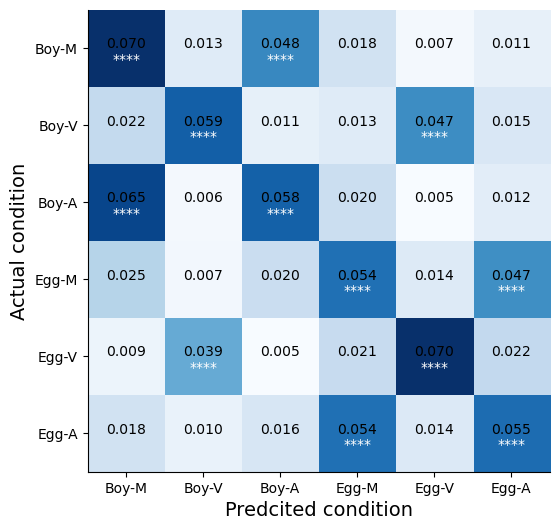

In [28]:
# plot contingency matrix
fig,ax = plt.subplots(figsize=(6,6))
#cax = fig.add_axes([0,0.3,0.05,0.5])

im = ax.imshow(real_mean, cmap=plt.cm.get_cmap('Blues'));
ax.set_xlabel('Predcited condition', fontsize=14)
ax.set_ylabel('Actual condition', fontsize=14)

for m in range(6):
    for l in range(6):        
        ax.text(m,l,'{:.3f}'.format(real_mean[l,m]),ha='center')
        
        pval_crit = [np.percentile(shuffle_mean[:,m,l],95), np.percentile(shuffle_mean[:,m,l],99),
                     np.percentile(shuffle_mean[:,m,l],99.9), np.percentile(shuffle_mean[:,m,l],99.99)]
        if real_mean[l,m] > pval_crit[3]:
            ax.text(m,l+0.2,'****', ha='center', color='white')
        elif real_mean[l,m] > pval_crit[2]:
            ax.text(m,l+0.2,'***', ha='center', color='white')
        elif real_mean[l,m] > pval_crit[1]:
            ax.text(m,l+0.2,'**', ha='center', color='white')
        elif real_mean[l,m] > pval_crit[0]:
            ax.text(m,l+0.2,'*', ha='center', color='white')

ax.set_xticks(np.arange(0,6))
ax.set_xticklabels(['Boy-M','Boy-V','Boy-A','Egg-M','Egg-V','Egg-A']);
ax.set_yticks(np.arange(0,6))
ax.set_yticklabels(['Boy-M','Boy-V','Boy-A','Egg-M','Egg-V','Egg-A']);

#fig.colorbar(im, cax = cax, orientation='vertical')
#plt.savefig(fig_path / 'svg' / 'confusion_all_conditions.svg')
#plt.tight_layout()

### Contribution to decoding by different cell categories (Fig 7C)
This analysis utilize permutation feature importance approach to quantify relative contribution to the decoding accuracy by different cell categories (unimodal cell vs. crossmodal cell).

In [10]:
def subsample_category(df, rat, num_trial, bin_size, time_bin):
    scaler = StandardScaler()
    
    num_bin = int(90/bin_size)
    
    object_cell_list = df.loc[df['rat']==int(rat),'key'].to_numpy()

    crossmodal_cell_list = df.loc[(df['rat']==int(rat))&(df['Category']=='crossmodal'),'key'].to_numpy()
    visual_cell_list = df.loc[(df['rat']==int(rat))&(df['Category']=='visual'),'key'].to_numpy()
    auditory_cell_list = df.loc[(df['rat']==int(rat))&(df['Category']=='auditory'),'key'].to_numpy()

    X_visual = np.zeros((6*num_trial, len(visual_cell_list)*time_bin))
    X_auditory = np.zeros((6*num_trial, len(auditory_cell_list)*time_bin))
    X_crossmodal = np.zeros((6*num_trial, len(crossmodal_cell_list)*time_bin))

    v, a, u = 0, 0, 0
    
    for i,cell_key in enumerate(object_cell_list):
    
        # load trial-by-trial firing rate data of a cell
        key = str(cell_key).zfill(4)
        cell_filename = list(cell_path.glob(f'{key}*.csv'))
        df_cell = pd.read_csv(cell_filename[0])
        df_cell.drop(df_cell[df_cell.Correctness==0].index,inplace=True)
        df_cell.reset_index(inplace=True,drop=True)
        
        category = df.loc[df.key==cell_key,'Category'].values[0]
        
        # goal location (left or right) of each object condition
        boy_goal = df_cell.loc[df_cell['Visual']=='Boy','RWD_Loc'].values[0]
        egg_goal = df_cell.loc[df_cell['Visual']=='Egg','RWD_Loc'].values[0]

        # stimulus condition (identity x modality)
        cond = [(df_cell['Type']=='Multimodal')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Visual')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Auditory')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Multimodal')&(df_cell['RWD_Loc']==egg_goal),
                (df_cell['Type']=='Visual')&(df_cell['RWD_Loc']==egg_goal),
                (df_cell['Type']=='Auditory')&(df_cell['RWD_Loc']==egg_goal)]

        fr_id = df_cell.columns.get_loc('Var10')  # get the index of the first firing rate column
        FR = df_cell.iloc[:,fr_id:].to_numpy()    # convert firing rate data to numpy array
    
        # recalculate mean firing rates of each time bin
        FR_bin = np.zeros((len(df_cell),time_bin))
        for b in range(time_bin):
            FR_bin[:,b] = FR[:,b*time_bin:(b+1)*time_bin].mean(axis=1)

        for c in range(len(cond)):
            # subsample n trials from each stimulus condition
            subsampled_trial = df_cell[cond[c]].sample(num_trial).index
            # firing rates of subsampled trials
            FR_sub = FR_bin[subsampled_trial,:]
    
            if category == 'visual':
                X_visual[num_trial*c:num_trial*(c+1), time_bin*v:time_bin*(v+1)] = FR_sub
            elif category == 'auditory':
                X_auditory[num_trial*c:num_trial*(c+1), time_bin*a:time_bin*(a+1)] = FR_sub
            elif category == 'crossmodal':
                X_crossmodal[num_trial*c:num_trial*(c+1), time_bin*u:time_bin*(u+1)] = FR_sub
        
        if category == 'visual':
            v += 1
        elif category == 'auditory':
            a += 1
        elif category == 'crossmodal':
            u += 1
            
    X_visual_norm = scaler.fit_transform(X_visual)
    X_auditory_norm = scaler.fit_transform(X_auditory)
    X_crossmodal_norm = scaler.fit_transform(X_crossmodal)

    return X_visual_norm, X_auditory_norm, X_crossmodal_norm

In [11]:
def permutation_feature_importance(df, model, rat, kfold, num_trial, bin_size, time_bin, same_num_cell):
    result = np.zeros((2,6,6))
    
    X_visual, X_auditory, X_crossmodal = subsample_category(df, rat, num_trial, bin_size, time_bin)
    
    v_count = int(np.shape(X_visual)[1]/9)
    a_count = int(np.shape(X_auditory)[1]/9)
    u_count = int(np.shape(X_crossmodal)[1]/9)
    # the number of cells to be permutated
    num_cell = min([v_count+a_count, u_count])
    
    X = np.hstack((X_visual, X_auditory, X_crossmodal))
    Y = np.repeat(np.arange(6), 5)

    skf = StratifiedKFold(n_splits=kfold, shuffle=True)
    for (train_index, test_index) in skf.split(X, Y):
        model.fit(X[train_index,:],Y[train_index])
        
        # permutation on visual & auditory cells
        X_VA = np.hstack((X_visual[test_index,:], X_auditory[test_index,:]))
        if same_num_cell:
            selected_VA = np.random.choice(int(np.shape(X_VA)[1]/9), num_cell, replace=False)
            for c in selected_VA:    # permutation on visual + auditory cells
                X_VA[:, 9*c:9*(c+1)] = np.random.permutation(X_VA[:, 9*c:9*(c+1)])
        else:
            X_VA = np.random.permutation(X_VA)
        X_VA_perm = np.hstack((X_VA, X_crossmodal[test_index,:]))
        pred_VA = model.predict(X_VA_perm)

        # permutation on crossmodal cells
        if same_num_cell:    # permutation on the same number of crossmodal cells with visual + auditory
            selected_crossmodal = np.random.choice(int(np.shape(X_crossmodal)[1]/9), num_cell, replace=False)
            for c in selected_crossmodal:
                X_crossmodal[:, 9*c:9*(c+1)] = np.random.permutation(X_crossmodal[:, 9*c:9*(c+1)])
        else:    # permuation on all crossmodal cells
            X_crossmodal = np.random.permutation(X_crossmodal)
        X_crossmodal_perm = np.hstack((X_visual[test_index,:], X_auditory[test_index,:], X_crossmodal[test_index,:]))
        pred_crossmodal = model.predict(X_crossmodal_perm)
        
        Y_test = Y[test_index]
        
        for j in range(len(pred_VA)):
            result[0,Y_test[j],int(pred_VA[j])] += 1
            result[1,Y_test[j],int(pred_crossmodal[j])] += 1

    return result

#### Perform permutation feature importance

In [ ]:
%%time

perm_same = np.zeros((2,len(rat_list),6,6))
perm_all = np.zeros((2,len(rat_list),6,6))

for r,rat in enumerate(rat_list):
    loop_start = time.time()

    perm_same_rat = Parallel(n_jobs=-1)(delayed(permutation_feature_importance)(df2, final_model, rat, kfold, num_trial, bin_size, 9, 1) for j in range(num_iter))   
    perm_all_rat = Parallel(n_jobs=-1)(delayed(permutation_feature_importance)(df2, final_model, rat, kfold, num_trial, bin_size, 9, 0) for j in range(num_iter))   

    perm_same[:,r,:,:] = np.sum(perm_same_rat,axis=0)/(num_iter*kfold*6)
    perm_all[:,r,:,:] = np.sum(perm_all_rat,axis=0)/(num_iter*kfold*6)

    loop_end = time.time()
    loop_time = divmod(loop_end-loop_start,60)
    print(f'LE{rat} completed /// Elapsed time: {int(loop_time[0])} min {loop_time[1]:.2f} sec')

np_save_path = save_path / 'all conditions' / 'permutation feature importance'
os.makedirs(np_save_path, exist_ok=True)
np.save(np_save_path / f'{today}_{bin_size*10}ms_{9}bins_{num_iter}iter_same.npy',perm_same)
np.save(np_save_path / f'{today}_{bin_size*10}ms_{9}bins_{num_iter}iter_all.npy',perm_all)

#### Load results and plot Fig 7C

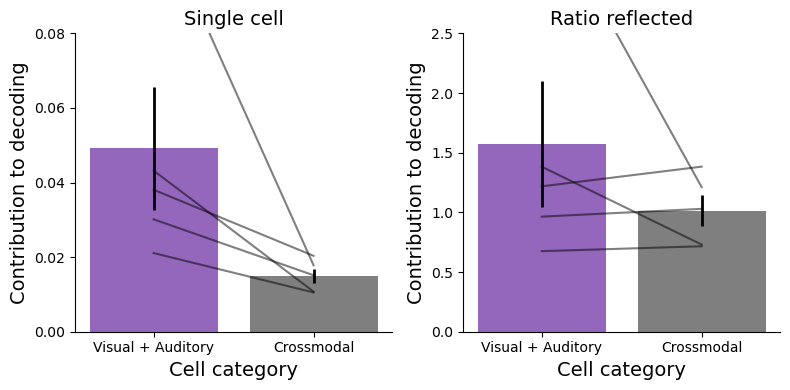

============== Paired t-test (all neurons) ==============
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  2.174092    4   two-sided  0.095372  [-0.01, 0.08]  1.305895  1.407   

           power  
T-test  0.597272  

========= Paired t-test (same number of neurons) =========
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  1.150099    4   two-sided  0.314185  [-0.79, 1.91]  0.651079  0.639   

           power  
T-test  0.203902  


In [32]:
np_path = save_path / 'modality_specific' / 'permutation feature importance'
load_date = '2023-08-01'

perm_all = np.load(np_path / f'{load_date}_{bin_size*10}ms_{9}bins_{num_iter}iter_all.npy')
real = np.load(save_path / 'modality_specific' / '2023-07-28_100ms_9bins_100iter_real.npy')
real = real/6

num_cell = np.zeros((5,2))
perm_all_result = np.zeros((5, 2))

prop_weight = [32, 68]

for i in range(5):
    num_cell[i,0] = df2.groupby(['rat', 'Category']).size()[rat_list[i]]['auditory']+\
    df2.groupby(['rat', 'Category']).size()[rat_list[i]]['visual']
    num_cell[i,1] = df2.groupby(['rat', 'Category']).size()[rat_list[i]]['crossmodal']
    
    real_result = np.trace(real[i,:,:])
    perm_all_result[i,0] = (real_result-np.trace(perm_all[0,i,:,:]))/(real_result+np.trace(perm_all[0,i,:,:]))
    perm_all_result[i,1] = (real_result-np.trace(perm_all[1,i,:,:]))/(real_result+np.trace(perm_all[1,i,:,:]))

fig, ax = plt.subplots(1,2, figsize=(8,4))

x = ['Visual + Auditory','Crossmodal']

y1 = perm_all_result/num_cell
y2 = (perm_all_result/num_cell)*prop_weight

ax[0].bar(x,np.mean(y1, axis=0), color=['tab:purple', 'tab:gray'])
ax[0].errorbar(x, np.mean(y1, axis=0), yerr=stats.sem(y1, axis=0), fmt='none', color='black', linewidth=2)
for i in range(5):
    ax[0].plot([y1[i,0], y1[i,1]], color='black', alpha=0.5)

ax[1].bar(x,np.mean(y2, axis=0), color=['tab:purple', 'tab:gray'])
ax[1].errorbar(x, np.mean(y2, axis=0), yerr=stats.sem(y2, axis=0), fmt='none', color='black', linewidth=2)
for i in range(5):
    ax[1].plot([y2[i,0], y2[i,1]], color='black', alpha=0.5)

t = ['Single cell', 'Ratio reflected']
for i in range(2):
    ax[i].set_title(t[i], fontsize=14)
    ax[i].set_xlabel('Cell category', fontsize=14)
    ax[i].set_ylabel('Contribution to decoding', fontsize=14)
ax[0].set_yticks(np.arange(0, 0.09, 0.02))
ax[0].set_ylim([0, 0.08])
ax[1].set_yticks(np.arange(0, 2.6, 0.5))
ax[1].set_ylim([0, 2.5])

plt.tight_layout()
#plt.savefig(fig_path / 'svg' / 'perm_importance_bar.svg')
plt.show()

ttest_all = pg.ttest(y1[:,0], y1[:,1], paired=True)
print('============== Paired t-test (all neurons) ==============')
print(ttest_all)
print('')

ttest_same = pg.ttest(y2[:,0], y2[:,1], paired=True)
print('========= Paired t-test (same number of neurons) =========')
print(ttest_same)

---

## Modality-invariant decoding (Fig 7D-F)

Object identities of multimodal trials are decoded based on unimodal (visual and auditory) trials.

In [ ]:
def subsample_cross(df, rat, num_trial, bin_size, time_bin, shuffle):
    scaler = StandardScaler()
    
    num_bin = int(90/bin_size)
    object_cell_list = df.loc[(df['rat']==rat)&(df['category']=='object'),'key'].to_numpy()
    
    # M by N array of subsampled firing rates
    # M = stimulus condition * number of subsampled trials
    # N = number of cells * number of time bins
    X = np.zeros((6*num_trial, len(object_cell_list)*time_bin))
    
    for i,cell_key in enumerate(object_cell_list):
    
        # load trial-by-trial firing rate data of a cell
        key = cell_key.zfill(4)
        cell_filename = list(cell_path.glob(f'{key}*.csv'))
        df_cell = pd.read_csv(cell_filename[0])
        df_cell.drop(df_cell[df_cell.Correctness==0].index,inplace=True)
        df_cell.reset_index(inplace=True,drop=True)
        
        # goal location (left or right) of each object condition
        boy_goal = df_cell.loc[df_cell['Visual']=='Boy','RWD_Loc'].values[0]
        egg_goal = df_cell.loc[df_cell['Visual']=='Egg','RWD_Loc'].values[0]
        
        # shuffling stimulus condition for permutation test
        if shuffle:
            cond_array = df_cell[['Type','RWD_Loc']].to_numpy()
            shuffled_cond_array = np.random.permutation(cond_array)
            df_cell[['Type','RWD_Loc']] = shuffled_cond_array

        # stimulus condition (identity x modality)
        cond = [(df_cell['Type']=='Multimodal')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Multimodal')&(df_cell['RWD_Loc']==egg_goal),
                (df_cell['Type']=='Visual')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Visual')&(df_cell['RWD_Loc']==egg_goal),                
                (df_cell['Type']=='Auditory')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Auditory')&(df_cell['RWD_Loc']==egg_goal)]

        fr_id = df_cell.columns.get_loc('Var10')  # get the index of the first firing rate column
        FR = df_cell.iloc[:,fr_id:].to_numpy()    # convert firing rate data to numpy array
    
        # recalculate mean firing rates of each time bin
        FR_bin = np.zeros((len(df_cell),time_bin))
        for b in range(time_bin):
            FR_bin[:,b] = FR[:,b*time_bin:(b+1)*time_bin].mean(axis=1)

        for c in range(len(cond)):
            # subsample n trials from each stimulus condition
            subsampled_trial = df_cell[cond[c]].sample(num_trial).index
            # firing rates of subsampled trials
            FR_sub = FR_bin[subsampled_trial,:]
            # add subsampled firing rate data to the result array
            X[num_trial*c:num_trial*(c+1), time_bin*i:time_bin*(i+1)] = FR_sub

        X_norm = scaler.fit_transform(X)
    
    return X_norm

In [ ]:
def subsample_crossmodal_predict(df, model, rat, num_trial, bin_size, time_bin, shuffle):

    result = np.zeros((2,2))

    X = subsample_cross(df, rat, num_trial, bin_size, time_bin, shuffle)

    X_multi = X[:10,:]
    Y_multi = np.repeat(np.arange(2), 5)
    
    X_uni = X[10:,:]
    Y_uni = np.concatenate((np.zeros(5), np.ones(5), np.zeros(5), np.ones(5)))

    # train with visual and test with auditory
    model.fit(X_uni,Y_uni)
    pred = model.predict(X_multi)

    for j in range(len(pred)):
        result[Y_multi[j],int(pred[j])] += 1

    return result

#### SVM parameter

In [ ]:
final_model = svm.SVC(kernel='linear', C=0.01)
kfold = 5
num_trial = 5
bin_size = 10
num_iter = 100
rat_list = ['600', '602', '640', '647', '699']

#### Real data

In [ ]:
%%time

np_save_path = save_path /'modality_invariant' / 'uni_to_multi'
os.makedirs(np_save_path, exist_ok=True)

for t in range(9):
    bin_loop_start = time.time()

    svm_real = np.zeros((len(rat_list),2,2))
    for i,rat in enumerate(rat_list):
        loop_start = time.time()

        rat_result = Parallel(n_jobs=-1)(delayed(subsample_crossmodal_predict)(df, final_model, rat, num_trial, bin_size, t+1, 0) for j in range(num_iter))   

        svm_real[i,:,:] = np.sum(rat_result,axis=0)/(num_iter*10)

        loop_end = time.time()
        loop_time = divmod(loop_end-loop_start,60)
        print(f'LE{rat} completed /// Elapsed time: {int(loop_time[0])} min {loop_time[1]:.2f} sec')

    np.save(np_save_path / f'{today}_{bin_size*10}ms_{t+1}bins_{num_iter}iter_generalization_real.npy',svm_real)

    bin_loop_end = time.time()
    bin_loop_time = divmod(bin_loop_end-bin_loop_start,60)
    print('---------------------------------------------------')
    print(f'{t+1} timebin completed / Elapsed time: {int(bin_loop_time[0])} min {bin_loop_time[1]:.2f} sec')
    print('===================================================')
    print('')    

#### Shuffled data

In [ ]:
%%time
num_shuffle = 1000

np_save_path = save_path /'modality_invariant' / 'uni_to_multi'
os.makedirs(np_save_path, exist_ok=True)

for t in range(9):
    bin_loop_start = time.time()
    
    svm_shuffle_result = np.zeros((num_shuffle,len(rat_list),2,2))
    for shuffle_run in range(num_shuffle):
        
        # measure elapsed time for every 100 loops
        if divmod(shuffle_run+1,100)[1] == 1:
            loop_start = time.time()
            
        svm_result = np.zeros((len(rat_list),2,2))
        for r,rat in enumerate(rat_list):
            rat_result = Parallel(n_jobs=-1)(delayed(subsample_crossmodal_predict)(df, final_model, rat, num_trial, bin_size, t+1, 1) for j in range(num_iter))
            
            svm_result[r,:,:] = np.sum(rat_result,axis=0)/(num_iter*10)

        svm_shuffle_result[shuffle_run,:,:,:] = svm_result
    
        # measure elapsed time for every 100 loops
        if divmod(shuffle_run+1,100)[1] == 0:
            loop_end = time.time()
            loop_time = divmod(loop_end-loop_start,60)
            print(f'Shuffle run {shuffle_run+1} completed /// Elapsed time: {int(loop_time[0])} min {loop_time[1]:.2f} sec')

            
    np.save(np_save_path / f'{today}_{bin_size*10}ms_{t+1}bins_{num_iter}iter_generalization_shuffle.npy',svm_shuffle_result)

    bin_loop_end = time.time()
    bin_loop_time = divmod(bin_loop_end-bin_loop_start,60)
    print('---------------------------------------------------')
    print(f'{t+1} timebin completed / Elapsed time: {int(bin_loop_time[0])} min {bin_loop_time[1]:.2f} sec')
    print('===================================================')
    print('')

### Evaluating modality-invariant decoding result (Fig 7E)

In [44]:
load_date = '2023-07-31'

real_data = np.load(save_path / 'modality_invariant' / 'uni_to_multi' / f'{load_date}_{bin_size*10}ms_{9}bins_{num_iter}iter_crossmodal_real.npy')
shuffle_data = np.load(save_path / 'modality_invariant' / 'uni_to_multi' / f'{load_date}_{bin_size*10}ms_{9}bins_{num_iter}iter_crossmodal_shuffle.npy')

real_mean = np.mean(real_data, axis=0)
shuffle_mean = np.mean(shuffle_data, axis=1)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_21672\2796119464.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.imshow(real_mean[:,:], cmap=plt.cm.get_cmap('Blues'));


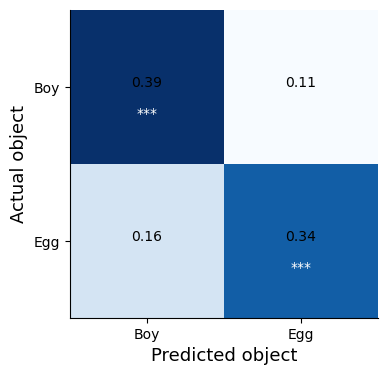

In [45]:
# plot contingency matrix
fig,ax = plt.subplots(figsize=(4,4))

ax.imshow(real_mean[:,:], cmap=plt.cm.get_cmap('Blues'));

t = ['Visual to Auditory', 'Auditory to Visual']
for m in range(2):
    for l in range(2):
        ax.text(m,l,'{:.2f}'.format(real_mean[l,m]),ha='center')
        pval_crit = [np.percentile(shuffle_mean[:,l,m],95), np.percentile(shuffle_mean[:,l,m],99),
                     np.percentile(shuffle_mean[:,l,m],99.9)]
        if real_mean[l,m] > pval_crit[2]:
            ax.text(m,l+0.2,'***', ha='center', color='white')
        elif real_mean[l,m] > pval_crit[1]:
            ax.text(m,l+0.2,'**', ha='center', color='white')
        elif real_mean[l,m] > pval_crit[0]:
            ax.text(m,l+0.2,'*', ha='center', color='white')

    ax.set_xlabel('Predicted object', fontsize=13)
    ax.set_ylabel('Actual object', fontsize=13)
    ax.set_xticks(np.arange(0,2))
    ax.set_xticklabels(['Boy', 'Egg']);
    ax.set_yticks(np.arange(0,2))
    ax.set_yticklabels(['Boy', 'Egg']);

#plt.savefig(fig_path / 'svg' / 'confusion_generalization.svg')

### Contribution to decoding by different cell categories (Fig 7F)
This analysis utilize permutation feature importance approach to quantify relative contribution to the decoding accuracy by different cell categories (unimodal cell vs. crossmodal cell).

In [ ]:
def subsample_category(df, rat, num_trial, bin_size, time_bin):
    scaler = StandardScaler()
    
    num_bin = int(90/bin_size)
    
    object_cell_list = df.loc[df['rat']==int(rat),'key'].to_numpy()

    unbiased_cell_list = df.loc[(df['rat']==int(rat))&(df['Category']=='unbiased'),'key'].to_numpy()
    visual_cell_list = df.loc[(df['rat']==int(rat))&(df['Category']=='visual'),'key'].to_numpy()
    auditory_cell_list = df.loc[(df['rat']==int(rat))&(df['Category']=='auditory'),'key'].to_numpy()

    X_visual = np.zeros((6*num_trial, len(visual_cell_list)*time_bin))
    X_auditory = np.zeros((6*num_trial, len(auditory_cell_list)*time_bin))
    X_unbiased = np.zeros((6*num_trial, len(unbiased_cell_list)*time_bin))

    v, a, u = 0, 0, 0
    
    for i,cell_key in enumerate(object_cell_list):

        # load trial-by-trial firing rate data of a cell
        key = str(cell_key).zfill(4)
        cell_filename = list(cell_path.glob(f'{key}*.csv'))
        df_cell = pd.read_csv(cell_filename[0])
        df_cell.drop(df_cell[df_cell.Correctness==0].index,inplace=True)
        df_cell.reset_index(inplace=True,drop=True)

        category = df.loc[df.key==cell_key,'Category'].values[0]

        # goal location (left or right) of each object condition
        boy_goal = df_cell.loc[df_cell['Visual']=='Boy','RWD_Loc'].values[0]
        egg_goal = df_cell.loc[df_cell['Visual']=='Egg','RWD_Loc'].values[0]

        # stimulus condition (identity x modality)
        cond = [(df_cell['Type']=='Multimodal')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Multimodal')&(df_cell['RWD_Loc']==egg_goal),
                (df_cell['Type']=='Visual')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Visual')&(df_cell['RWD_Loc']==egg_goal),                
                (df_cell['Type']=='Auditory')&(df_cell['RWD_Loc']==boy_goal),
                (df_cell['Type']=='Auditory')&(df_cell['RWD_Loc']==egg_goal)]

        fr_id = df_cell.columns.get_loc('Var10')  # get the index of the first firing rate column
        FR = df_cell.iloc[:,fr_id:].to_numpy()    # convert firing rate data to numpy array

        # recalculate mean firing rates of each time bin
        FR_bin = np.zeros((len(df_cell),time_bin))
        for b in range(time_bin):
            FR_bin[:,b] = FR[:,b*time_bin:(b+1)*time_bin].mean(axis=1)

        for c in range(len(cond)):
            # subsample n trials from each stimulus condition
            subsampled_trial = df_cell[cond[c]].sample(num_trial).index
            # firing rates of subsampled trials
            FR_sub = FR_bin[subsampled_trial,:]
    
            if category == 'visual':
                X_visual[num_trial*c:num_trial*(c+1), time_bin*v:time_bin*(v+1)] = FR_sub
            elif category == 'auditory':
                X_auditory[num_trial*c:num_trial*(c+1), time_bin*a:time_bin*(a+1)] = FR_sub
            elif category == 'unbiased':
                X_unbiased[num_trial*c:num_trial*(c+1), time_bin*u:time_bin*(u+1)] = FR_sub
        
        if category == 'visual':
            v += 1
        elif category == 'auditory':
            a += 1
        elif category == 'unbiased':
            u += 1
            
    X_visual_norm = scaler.fit_transform(X_visual)
    X_auditory_norm = scaler.fit_transform(X_auditory)
    X_unbiased_norm = scaler.fit_transform(X_unbiased)

    return X_visual_norm, X_auditory_norm, X_unbiased_norm

In [ ]:
def permutation_feature_importance(df, model, rat, num_trial, bin_size, time_bin, same_num_cell):
    result = np.zeros((2,2,2))
    
    X_visual, X_auditory, X_unbiased = subsample_category(df, rat, num_trial, bin_size, time_bin)

    v_count = int(np.shape(X_visual)[1]/9)
    a_count = int(np.shape(X_auditory)[1]/9)
    u_count = int(np.shape(X_unbiased)[1]/9)
    # the number of cells to be permutated
    num_cell = min([v_count+a_count, u_count])

    X = np.hstack((X_visual, X_auditory, X_unbiased))
    X_uni = X[10:,:]
    Y_uni = np.concatenate((np.zeros(5), np.ones(5), np.zeros(5), np.ones(5)))

    # train with unimodal trials using all cells
    model.fit(X_uni, Y_uni)

    # permutation on visual & auditory cells
    X_VA = np.hstack((X_visual, X_auditory))    # input X only with visual and auditory cells
    if same_num_cell:    # permutation on the same number of visual + auditory cells with unbiased cells
        selected_VA = np.random.choice(int(np.shape(X_VA)[1]/9), num_cell, replace=False)
        for c in selected_VA:    # permutation on all visual + auditory cells
            X_VA[:, 9*c:9*(c+1)] = np.random.permutation(X_VA[:, 9*c:9*(c+1)])
    else:
        X_VA = np.random.permutation(X_VA)
    X_VA_perm = np.hstack((X_VA, X_unbiased))
    pred_VA = model.predict(X_VA_perm[:10,:])

    # permutation on unbiased cells
    if same_num_cell:    # permutation on the same number of unbiased cells with visual + auditory
        selected_unbiased = np.random.choice(int(np.shape(X_unbiased)[1]/9), num_cell, replace=False)
        for c in selected_unbiased:
            X_unbiased[:, 9*c:9*(c+1)] = np.random.permutation(X_unbiased[:, 9*c:9*(c+1)])
    else:    # permuation on all unbiased cells
        X_unbiased = np.random.permutation(X_unbiased)
    X_unbiased_perm = np.hstack((X_visual, X_auditory, X_unbiased))
    pred_unbiased = model.predict(X_unbiased_perm[:10,:])

    Y_multi = np.repeat(np.arange(2), 5)

    for i in range(len(pred_VA)):
        result[0, Y_multi[i], int(pred_VA[i])] += 1
        result[1, Y_multi[i], int(pred_unbiased[i])] += 1

    return result

In [ ]:
%%time

perm_same = np.zeros((2,len(rat_list),2,2))
perm_all = np.zeros((2,len(rat_list),2,2))

for r,rat in enumerate(rat_list):
    loop_start = time.time()

    perm_same_rat = Parallel(n_jobs=-1)(delayed(permutation_feature_importance)(df2, final_model, rat, num_trial, bin_size, 9, 1) for j in range(num_iter))   
    perm_all_rat = Parallel(n_jobs=-1)(delayed(permutation_feature_importance)(df2, final_model, rat, num_trial, bin_size, 9, 0) for j in range(num_iter))   

    perm_same[:,r,:,:] = np.sum(perm_same_rat,axis=0)/(num_iter*10)
    perm_all[:,r,:,:] = np.sum(perm_all_rat,axis=0)/(num_iter*10)

    loop_end = time.time()
    loop_time = divmod(loop_end-loop_start,60)
    print(f'LE{rat} completed /// Elapsed time: {int(loop_time[0])} min {loop_time[1]:.2f} sec')

np_save_path = save_path / 'modality_invariant' / 'uni_to_multi' / 'permutation feature importance'
os.makedirs(np_save_path, exist_ok=True)
np.save(np_save_path / f'{today}_{bin_size*10}ms_{9}bins_{num_iter}iter_same.npy',perm_same)
np.save(np_save_path / f'{today}_{bin_size*10}ms_{9}bins_{num_iter}iter_all.npy',perm_all)

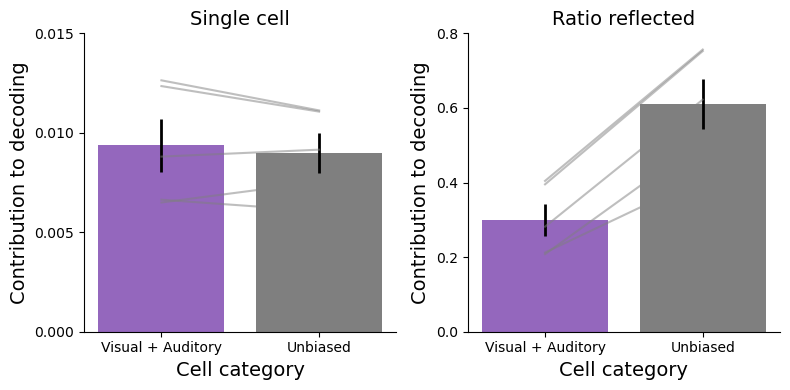

============== Paired t-test (all neurons) ==============
               T  dof alternative     p-val        CI95%   cohen-d   BF10  \
T-test  0.819647    4   two-sided  0.458446  [-0.0, 0.0]  0.150677  0.515   

           power  
T-test  0.058084  

========= Paired t-test (same number of neurons) =========
                T  dof alternative     p-val           CI95%   cohen-d  \
T-test -10.678338    4   two-sided  0.000436  [-0.39, -0.23]  2.469728   

          BF10     power  
T-test  69.296  0.979601  


In [40]:
np_path = save_path / 'modality_invariant' / 'uni_to_multi' / 'permutation feature importance'
load_date = '2023-08-01'

perm_same = np.load(np_path / f'{load_date}_{bin_size*10}ms_{9}bins_{num_iter}iter_same.npy')
perm_all = np.load(np_path / f'{load_date}_{bin_size*10}ms_{9}bins_{num_iter}iter_all.npy')
real = np.load(save_path / 'modality_invariant' / 'uni_to_multi' / '2023-07-31_100ms_9bins_100iter_crossmodal_real.npy')

num_cell = np.zeros((5,2))
perm_all_result = np.zeros((5, 2))

prop_weight = [32, 68]

for i in range(5):
    num_cell[i,0] = df2.groupby(['rat', 'Category']).size()[rat_list[i]]['auditory']+\
    df2.groupby(['rat', 'Category']).size()[rat_list[i]]['visual']
    num_cell[i,1] = df2.groupby(['rat', 'Category']).size()[rat_list[i]]['crossmodal']
    
    real_result = np.trace(real[i,:,:])
    perm_all_result[i,0] = (real_result-np.trace(perm_all[0,i,:,:]))/(real_result + np.trace(perm_all[0,i,:,:]))
    perm_all_result[i,1] = (real_result-np.trace(perm_all[1,i,:,:]))/(real_result + np.trace(perm_all[1,i,:,:]))

fig, ax = plt.subplots(1,2, figsize=(8,4))

x = ['Visual + Auditory','Unbiased']

y1 = perm_all_result/num_cell
y2 = (perm_all_result/num_cell)*prop_weight

ax[0].bar(x,np.mean(y1, axis=0), color=['tab:purple', 'tab:gray'])
ax[0].errorbar(x, np.mean(y1, axis=0), yerr=stats.sem(y1, axis=0), fmt='none', color='black', linewidth=2)
for i in range(5):
    ax[0].plot([y1[i,0], y1[i,1]], color='tab:gray', alpha=0.5)

ax[1].bar(x,np.mean(y2, axis=0), color=['tab:purple', 'tab:gray'])
ax[1].errorbar(x, np.mean(y2, axis=0), yerr=stats.sem(y2, axis=0), fmt='none', color='black', linewidth=2)
for i in range(5):
    ax[1].plot([y2[i,0], y2[i,1]], color='tab:gray', alpha=0.5)

t = ['Single cell', 'Ratio reflected']
for i in range(2):
    ax[i].set_title(t[i], fontsize=14)
    ax[i].set_xlabel('Cell category', fontsize=14)
    ax[i].set_ylabel('Contribution to decoding', fontsize=14)
ax[0].set_yticks(np.arange(0, 0.016, 0.005))
ax[0].set_ylim([0, 0.015])
ax[1].set_yticks(np.arange(0, 0.9, 0.2))
ax[1].set_ylim([0, 0.8])

plt.tight_layout()
#plt.savefig(fig_path / 'svg' / 'generalization_perm_importance_bar.svg')
plt.show()

ttest_all = pg.ttest(y1[:,0], y1[:,1], paired=True)
print('============== Paired t-test (all neurons) ==============')
print(ttest_all)
print('')

ttest_same = pg.ttest(y2[:,0], y2[:,1], paired=True)
print('========= Paired t-test (same number of neurons) =========')
print(ttest_same)